In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 0. Data Reading and Handling

In [3]:
df_eng = pd.read_csv('Eng.csv')
df_eng.columns = ['word']
df_eng['language'] = 'eng'

In [4]:
df_eng[df_eng['word'].isna()]

,word,language
19278,NaN,eng


- pandas csv_reader interpreted the word 'null' as NaN so I fix that

In [5]:
df_eng = df_eng.fillna('null') 

In [6]:
df_tr = pd.read_csv('Turkish.csv')
df_tr.columns = ['word']
df_tr['language'] = 'tr'

In [7]:
df_tr[df_tr['word'].str.contains(' ')]

,word,language
223,bes on,tr
357,v yaka,tr
533,el gun,tr
605,ak kan,tr
680,ak yem,tr
750,lop et,tr
919,on soz,tr
961,on kol,tr
994,oz isi,tr
1054,uc iki,tr


- There are some words that are not actually single words.
- I will create new rows by splitting them
- I will drop 'v' since it is a single letter with no meaning without 'yaka'
- I will also drop duplicates in the cases above since there are many'on'

In [8]:
singlized_words = np.unique(np.reshape(df_tr[df_tr['word'].str.contains(' ')]['word'].str.split(" ").values.tolist(), -1))
singlized_words = singlized_words[singlized_words != 'v']
print(singlized_words)

['ak' 'bes' 'el' 'et' 'gun' 'ic' 'iki' 'isi' 'kan' 'kol' 'lop' 'on' 'oz'
 'soz' 'uc' 'yaka' 'yem']


- Now drop rows with double words and add these words into the dataframe as rows

In [9]:
df_tr = df_tr[~df_tr['word'].str.contains(' ')]

In [10]:
df_tr[df_tr['word'].str.contains(' ')]

,word,language


- Done

In [11]:
df_tr = pd.concat([df_tr, pd.DataFrame({'word': singlized_words, 'language': 'tr'})]).reset_index(
    drop = True)
df_tr.tail(10)

,word,language
2231,isi,tr
2232,kan,tr
2233,kol,tr
2234,lop,tr
2235,on,tr
2236,oz,tr
2237,soz,tr
2238,uc,tr
2239,yaka,tr
2240,yem,tr


- OK they are added to the tail

- Finally I can merge both tr and eng words into single table

In [12]:
df = pd.concat([df_eng, df_tr]).reset_index(drop = True)

# 2. Junk Word Classification: 
## Anomaly / Novelty Detection

- In the problem definition, it is clearly stated that we assume data does NOT contain any junk words. That points out to NOVELTY detection, rather than outlier detection. Therefore this will be the method I am going to use to distinguish junk words from actual words.

Knowing that junk words are created by pressing the keyboard randomly, they carry two common features that are different from actual words:
- They have low number of unique letters in them, compared to their size. For example 'asdadasdasdsa' word is made of 13 letters but only 3 are unique. On the other hand, an actual word such as 'distinctive' is made of 11 letters, 8 of which are unique. Therefore, while junk words have low number_of_unique_letters / number_of_letters ratio, actual words have a higher one, closer to 1.0.
- Since they are created by a fast process on keyboard, they are made of letters that are very close to each other. I will measure this closeness with sum of 'Manhattan Distance's between letters / Number of Letters in Word. Manhattan distance is sum of the horizontal and vertical distance between objects. This metric makes sense because it is unlikely to make a typo with a letter that is not adjacent. Sum of manhattan distances of consecutive letters are divided by the length of the word to normalize it so that it will be possible to evalulate long and short words in a more justified way.

### Extra Features that I could use

- number of repetetive letters
- max of, number of consecutive vowel islands
- max of, number of consecutive consonant islands
- number of repetetive letters 'aaaadd' 4 and 2, so there are 2 repetitions
- max of repetitions, for example 'aaaadd' 4

- Helper objects and functions that will allow me to calculate Manhattan Distance between letters in Keyboard

In [356]:
# Q-EN Keyboard Representation
first_line = ['q', 'w', 'e', 'r', 't', 'y', 'u', 'i', 'o', 'p']
second_line = ['a', 's', 'd', 'f', 'g', 'h', 'j', 'k', 'l']
third_line = ['z', 'x', 'c', 'v', 'b', 'n', 'm']

# Helper functions that calculate the Manhattan Distance between Letters in English-Q keyboard
def position(letter):
    if letter in first_line:
        position_of_letter = (0, first_line.index(letter))
    elif letter in second_line:
        position_of_letter = (1, second_line.index(letter))
    else:
        position_of_letter = (2, third_line.index(letter))
    return position_of_letter

def manhattan_distance(first_letter, second_letter):
    position_of_first_letter = position(first_letter)
    position_of_second_letter = position(second_letter)
    
    return abs(position_of_first_letter[0] - position_of_second_letter[0]) + abs(
        position_of_first_letter[1] - position_of_second_letter[1])

- Range of features are different. While unique_letters_len_ratio's range is (0, 1), manhattan_len_ratio's range is (0, 8) in this dataset. Normally, it is good practice to scale and normalize the features, in order to prevent any bias towards a single feature, however I've seen that normalizing results in a incredible decrease in model success, from 0.8 to 0.5-ish. So I commented out the scaling code.

In [357]:
# Novelty Detection Features
def novelty_detection_features(array):
    lst_novelty_features = []
    #scaler = MinMaxScaler()
    for word in array:
        sum_of_manh_dist = 0
        for i in range(len(word) - 1):
            first_letter = word[i]
            second_letter = word[i+1]
            sum_of_manh_dist += manhattan_distance(first_letter, second_letter)

        manhattan_len_ratio = sum_of_manh_dist / len(word)

        # ----------------------------------------------------------------

        number_of_unique_letters = len(np.unique(list(word)))
        unique_letters_len_ratio = number_of_unique_letters / len(word)

        # ----------------------------------------------------------------
        lst_novelty_features.append([manhattan_len_ratio, unique_letters_len_ratio])
        
    
    #lst_novelty_features = scaler.fit_transform(lst_novelty_features)
        
    df_nov = pd.DataFrame(lst_novelty_features, columns = ['manh_len_ratio', 'unique_letters_len_ratio'])
    df_nov['word'] = array
    
    return df_nov

In [358]:
df_nov = novelty_detection_features(df['word'])

In [359]:
df_nov.sort_values(by = 'unique_letters_len_ratio').head(10)

,manh_len_ratio,unique_letters_len_ratio,word
1035,0.000000,0.250000,mmmm
8196,0.000000,0.250000,oooo
2870,2.000000,0.333333,beebee
1909,1.000000,0.333333,muumuu
21129,4.666667,0.333333,kakkak
2993,3.000000,0.333333,booboo
12045,1.500000,0.333333,geggee
4056,5.000000,0.333333,zoozoo
10400,2.400000,0.400000,ululu
4911,0.800000,0.400000,essee


In [360]:
df_nov.sort_values(by = 'manh_len_ratio').head(10)

,manh_len_ratio,unique_letters_len_ratio,word
8196,0.0,0.25,oooo
1035,0.0,0.25,mmmm
15853,0.5,0.50,sass
14895,0.5,0.75,reed
6288,0.5,0.50,loll
13976,0.5,0.50,deed
7095,0.5,0.75,loop
10751,0.5,0.75,pool
11571,0.5,0.50,poop
14954,0.6,0.60,rfree


- Even though it was stated that the data does not contain any junk words, it seems both features are able to show made-up words for low values although some actual words also exist in low manhattan_distance / length ratio values such as 'deed', 'pool', 'poop'

In [361]:
X_train = df_nov.drop('word', axis = 1)

- Visual Inspection at Data

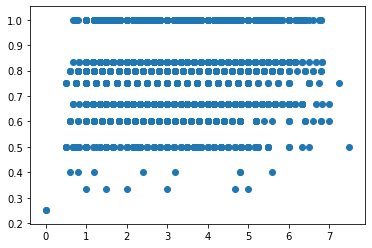

In [362]:
plt.scatter(data = X_train, x = X_train.columns[0], y = X_train.columns[1])

- I dont really see clear distinction, though points get sparser in low values of Y axis

- I create some new words to test the model, 0.5 junk and 0.5 actual words, both turkish and english

In [363]:
test_words = ['asdadsadasda', 'qwewqewqewqeqw', 'xcvcxvcxvcxvcxvx', 'poipoipoipoipoip', 'jkjkjkjk', 
              'iiiiiiiiiii', 'aaaaaaaaaa', 'oooooooooo', 'sgfqwgqgqgqg', 'huahuahuhuahuahuahua', 'zuhauhauhauhauh',
              'hjghjghjghj', 'hahahahhahahaha', 'jajajajaj', 'xaxaxaxaxaxaxa',
              'meliksah', 'turker',  'data', 'scientist', 'advanced', 'analytics',
              'machine', 'learning', 'bogazici', 'besiktas', 'maltepe', 'istanbul',
              'teknik', 'online', 'services']
y_test = 15 * [-1] + 15 * [1]

In [364]:
df_test = novelty_detection_features(test_words)

In [365]:
df_test.head(3)

,manh_len_ratio,unique_letters_len_ratio,word
0,1.333333,0.250000,asdadsadasda
1,1.214286,0.214286,qwewqewqewqeqw
2,1.250000,0.187500,xcvcxvcxvcxvcxvx


In [366]:
X_test = df_test.drop('word', axis = 1)

In [406]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors = 3, novelty = True)
clf.fit(X_train)
y_predicted = clf.predict(X_test)
y_probs = clf.decision_function(X_test)
y_gt = y_test

In [407]:
metrics.accuracy_score(y_test, y_predicted)
accuracy = metrics.accuracy_score(y_gt, y_predicted)
recall = metrics.recall_score(y_gt, y_predicted)
precision = metrics.precision_score(y_gt, y_predicted)
f1 = metrics.f1_score(y_gt, y_predicted)
pd.DataFrame([accuracy, recall, precision, f1], columns = ['LocalOutlierFactor'], 
             index = ['Accuracy', 'Recall', 'Precision', 'F1_Score'])

,LocalOutlierFactor
Accuracy,0.80
Recall,0.60
Precision,1.00
F1_Score,0.75


- I predicted with an accuracy of 0.8 and perfect precision
- Let's test the result for different parameters of our classifier

In [348]:
metric_results = []
for n_neighbors in range(2, 30, 1):
    clf = LocalOutlierFactor(n_neighbors = n_neighbors, novelty = True)
    clf.fit(X_train)
    y_predicted = clf.predict(X_test)
    metric_results.append(metrics.accuracy_score(y_test, y_predicted))

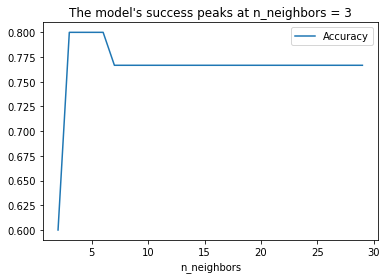

In [349]:
pd.DataFrame({'n_neighbors': range(2, 30, 1), 'Accuracy': metric_results}).plot(
    x = 'n_neighbors', y = 'Accuracy', 
    title = "The model's success peaks at n_neighbors = " + str(np.argmax(metric_results) + 2))

- I will try to tune this model by changing decision_function score(probability) threshold

In [432]:
lst_threshold = np.linspace(-2, 2, 1000)
lst_f1score = []
for threshold in lst_threshold:
    new_preds = (y_probs < threshold) * 1
    lst_f1score.append(metrics.accuracy_score((np.array(y_test) < 0), new_preds))

tuned_probability = lst_threshold[np.argmax(lst_f1score)]

Text(-0.062062062062061996, 0.8, 'x')

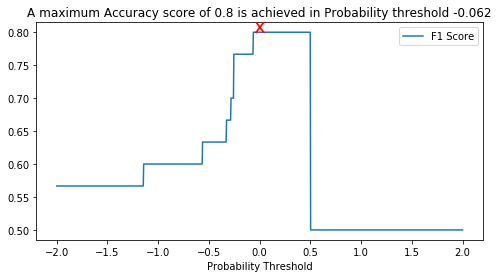

In [434]:
fig, ax = plt.subplots()
pd.DataFrame({'Probability Threshold': lst_threshold, 'F1 Score': lst_f1score}).set_index(
    'Probability Threshold').plot(ax = ax,
    title = "A maximum Accuracy score of " + str(round(max(lst_f1score), 3)) + " is achieved in Probability threshold " + str(round(lst_threshold[np.argmax(lst_f1score)], 3)), figsize = (8, 4))

#ax.axvline(tuned_probability, color = 'red')
ax.annotate('x', (tuned_probability, max(lst_f1score)), color = 'red', size = 20)

- So it was possible to increase the F1 score from 0.75 to 0.833. That's 11% improvement and is actually great!
- Let's check all metrics with the new, optimized threshold:

In [431]:
tuned_prob_preds = (y_probs < tuned_probability) * 1

accuracy = metrics.accuracy_score((np.array(y_test) < 0), tuned_prob_preds)
recall = metrics.recall_score((np.array(y_test) < 0), tuned_prob_preds)
precision = metrics.precision_score((np.array(y_test) < 0), tuned_prob_preds)
f1 = metrics.f1_score((np.array(y_test) < 0), tuned_prob_preds)
df_final_results = pd.DataFrame([accuracy, recall, precision, f1], 
                                columns = ['XGBoostClassifier'], 
                                index = ['Accuracy', 'Recall', 'Precision', 'F1_Score'])
df_final_results

,XGBoostClassifier
Accuracy,0.800000
Recall,1.000000
Precision,0.714286
F1_Score,0.833333


### Diagnostics of Novelty Detection

- I will inspect the words where the model made misclassifications and try to understand why

In [350]:
clf = LocalOutlierFactor(n_neighbors = 3, novelty = True)
clf.fit(X_train)
y_predicted = clf.predict(X_test)

In [351]:
df_diag = pd.DataFrame({'word': test_words, 'label': y_test, 'predicted': y_predicted})

- Misclassified words are:

In [352]:
df_diag[df_diag['label'] != df_diag['predicted']]

,word,label,predicted
20,analytics,1,-1
21,machine,1,-1
22,learning,1,-1
23,bogazici,1,-1
24,besiktas,1,-1
25,maltepe,1,-1


In [353]:
metrics.recall_score(y_test, y_predicted)

0.6

In [354]:
metrics.precision_score(y_test, y_predicted)

1.0

- It seems the model is able to identify junk words perfectly but sometimes misclassifies actual words as junk words, too.
- I will inspect which words existed in the training data

In [355]:
df_nov[df_nov['word'].isin(test_words)]['word']

8721     online
14270      data
23146      data
Name: word, dtype: object

- Only 'data' and 'online' words were in the training data so at least no overfitting or a bias occured

### Conclusion and Future Research

- Because it was suggested by scikit-learn and implied by saying 'all words in the data are assumed to be actual words', that I should not use Outlier Detection, I used Local Outlier Factor method, instead of Anomaly Detection, even though I saw that some words in the data were actually junk words.
- I was able to classify the junk words with 1.0 precision however doing so I also classified some actual words as junk.
- I tried to tune by changing probability threshold of the model. It didn't improve the Accuracy.
- More, additional features could be used but I think these two features were the best ones that distinguish junk from real ones.
    - I thought about features such as repetition of letters but that information already resides within my no_of_unique_features_len feature.